# **Importing the libraries**

In [68]:
# Data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP and text preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud

# Download NLTK resources
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# **Data Loading and Initial Exploration**

In [69]:
# Load the datasets
df_train = pd.read_csv('twitter_training.csv', header=None)
df_val = pd.read_csv('twitter_validation.csv', header=None)

In [70]:
# Combine the datasets
df = pd.concat([df_train, df_val], ignore_index=True)

In [71]:
# Rename columns for clarity
df.columns = ['tweet_id', 'entity', 'sentiment', 'tweet_text']

In [72]:
df.head()

,tweet_id,entity,sentiment,tweet_text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [73]:
# Display basic information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75682 entries, 0 to 75681
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_id    75682 non-null  int64 
 1   entity      75682 non-null  object
 2   sentiment   75682 non-null  object
 3   tweet_text  74996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [74]:
# Display descriptive statistics
df.describe(include='all')

,tweet_id,entity,sentiment,tweet_text
count,75682.000000,75682,75682,74996
unique,NaN,32,4,69974
top,NaN,TomClancysRainbowSix,Negative,It is not the first time that the EU Commissio...
freq,NaN,2435,22808,172
mean,6432.579583,NaN,NaN,NaN
std,3740.243463,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN
25%,3196.000000,NaN,NaN,NaN
50%,6423.000000,NaN,NaN,NaN
75%,9602.000000,NaN,NaN,NaN


In [75]:
# Check the distribution of original sentiments
df['sentiment'].value_counts()

,count
sentiment,
Negative,22808
Positive,21109
Neutral,18603
Irrelevant,13162


/tmp/ipython-input-76-1742843774.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='viridis')


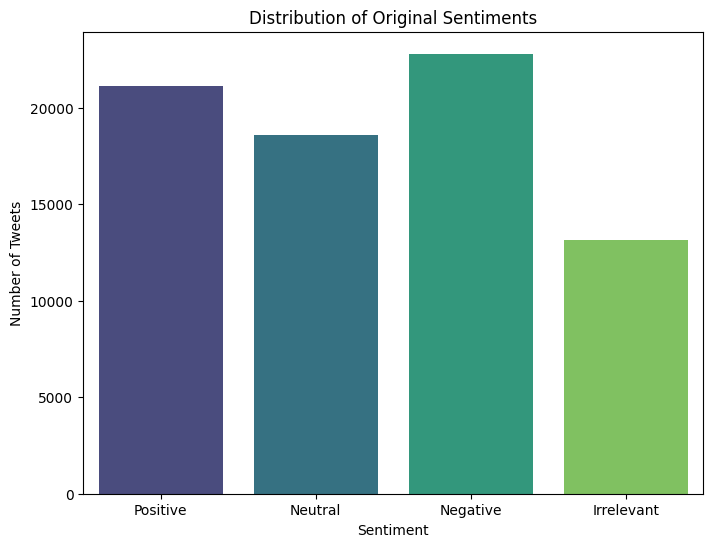

In [76]:
# Visualize the distribution of original sentiments
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, palette='viridis')
plt.title('Distribution of Original Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

# **Data Preprocessing**

In [77]:
import re

In [78]:
# Droping rows where 'tweet_text' is missing
df.dropna(subset=['tweet_text'], inplace=True)

In [79]:
# Initializing lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [80]:
# Function to clean and preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = str(text).lower()
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    # Remove mentions (@user) and hashtags (#tag)
    text = re.sub(r"@\w+|#\w+", "", text)
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize the text
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    from nltk.tokenize import word_tokenize
    tokens = word_tokenize(text)

    # Remove stop words and lemmatize
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return " ".join(cleaned_tokens)

In [81]:
# Apply the preprocessing function to the 'tweet_text' column
df['cleaned_text'] = df['tweet_text'].apply(preprocess_text)

In [82]:
# Display the first few rows with the cleaned text
df[['tweet_text', 'cleaned_text']].head()

,tweet_text,cleaned_text
0,im getting on borderlands and i will murder yo...,im getting borderland murder
1,I am coming to the borders and I will kill you...,coming border kill
2,im getting on borderlands and i will kill you ...,im getting borderland kill
3,im coming on borderlands and i will murder you...,im coming borderland murder
4,im getting on borderlands 2 and i will murder ...,im getting borderland murder


In [83]:
# Check for empty strings after cleaning (if any) and remove them
df = df[df['cleaned_text'].str.strip() != ''].reset_index(drop=True)

# **Sentiment Analysis (VADER)**

In [86]:
# Initialize VADER sentiment intensity analyzer
analyzer = SentimentIntensityAnalyzer()

In [87]:
# Function to get sentiment scores and classify sentiment
def get_vader_sentiment(text):
    vs = analyzer.polarity_scores(text)
    compound_score = vs['compound']

    if compound_score >= 0.05:
        sentiment = 'Positive'
    elif compound_score <= -0.05:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'
    return sentiment, compound_score

In [88]:
# Apply the sentiment analysis function to the 'cleaned_text' column
df[['vader_sentiment', 'compound_score']] = df['cleaned_text'].apply(lambda x: pd.Series(get_vader_sentiment(x)))

In [89]:
# Display the first few rows with sentiment scores
df[['tweet_text', 'cleaned_text', 'vader_sentiment', 'compound_score']].head()

,tweet_text,cleaned_text,vader_sentiment,compound_score
0,im getting on borderlands and i will murder yo...,im getting borderland murder,Negative,-0.6908
1,I am coming to the borders and I will kill you...,coming border kill,Negative,-0.6908
2,im getting on borderlands and i will kill you ...,im getting borderland kill,Negative,-0.6908
3,im coming on borderlands and i will murder you...,im coming borderland murder,Negative,-0.6908
4,im getting on borderlands 2 and i will murder ...,im getting borderland murder,Negative,-0.6908


In [90]:
# Check the distribution of VADER sentiments
df['vader_sentiment'].value_counts()


,count
vader_sentiment,
Positive,34526
Negative,27085
Neutral,11694


# **DATA VISUALISATION**

 # Sentiment Distribution

/tmp/ipython-input-91-4204108916.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='vader_sentiment', data=df, palette='coolwarm', order=['Positive', 'Neutral', 'Negative'])


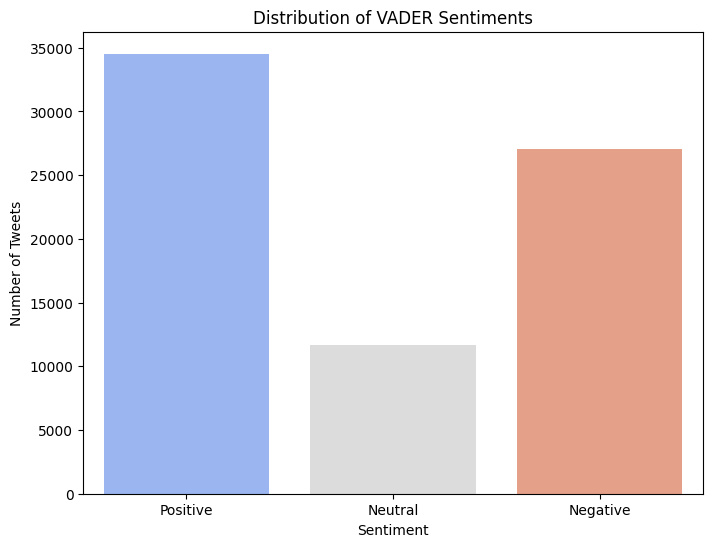

In [91]:
# Bar plot of VADER sentiment distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='vader_sentiment', data=df, palette='coolwarm', order=['Positive', 'Neutral', 'Negative'])
plt.title('Distribution of VADER Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

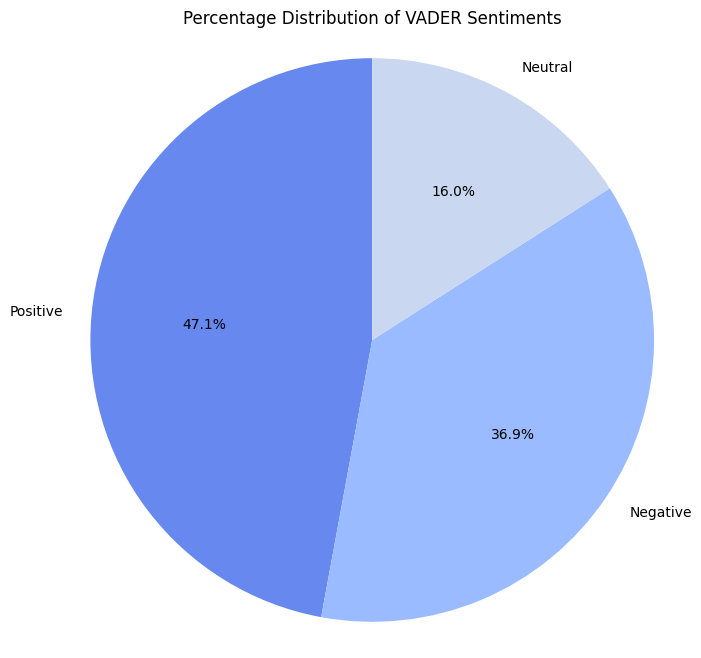

In [92]:
# Pie chart of VADER sentiment distribution
sentiment_counts = df['vader_sentiment'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=sns.color_palette('coolwarm'), startangle=90)
plt.title('Percentage Distribution of VADER Sentiments')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


# Word Clouds for Each Sentiment Category

In [94]:
# Separate text by sentiment
positive_text = " ".join(df[df['vader_sentiment'] == 'Positive']['cleaned_text'])
negative_text = " ".join(df[df['vader_sentiment'] == 'Negative']['cleaned_text'])
neutral_text = " ".join(df[df['vader_sentiment'] == 'Neutral']['cleaned_text'])

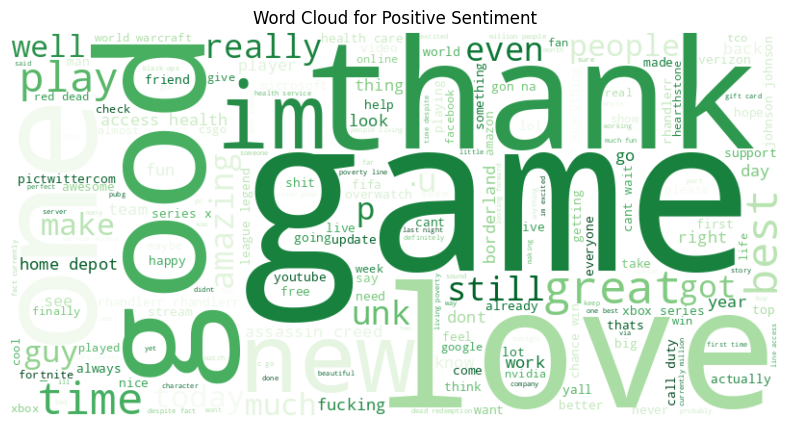

In [95]:
# Generate Word Cloud for Positive Sentiment
if positive_text:
    wordcloud_positive = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_positive, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for Positive Sentiment')
    plt.show()
else:
    print("No positive text available to generate word cloud.")

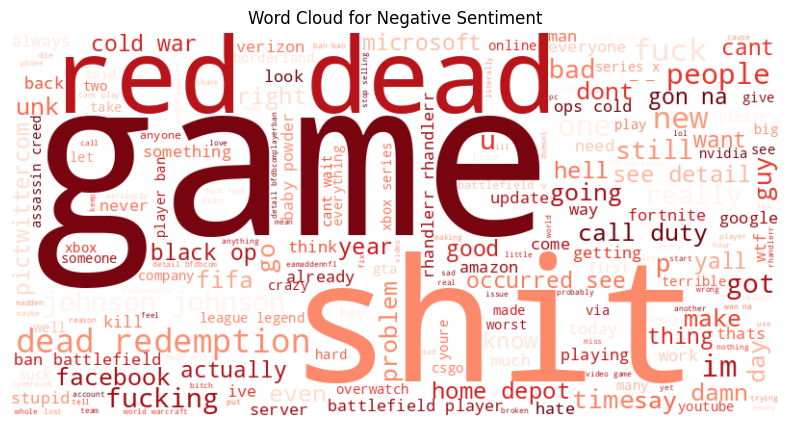

In [96]:
# Generate Word Cloud for Negative Sentiment
if negative_text:
    wordcloud_negative = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_negative, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for Negative Sentiment')
    plt.show()
else:
    print("No negative text available to generate word cloud.")

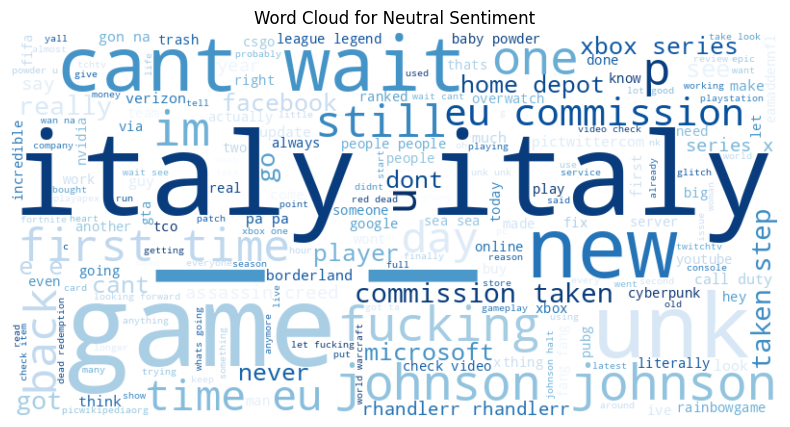

In [97]:
# Generate Word Cloud for Neutral Sentiment
if neutral_text:
    wordcloud_neutral = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(neutral_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_neutral, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for Neutral Sentiment')
    plt.show()
else:
    print("No neutral text available to generate word cloud.")
